In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# local
from LSM import MonteCarloOptionPricing
from DC import DynamicChebyshev

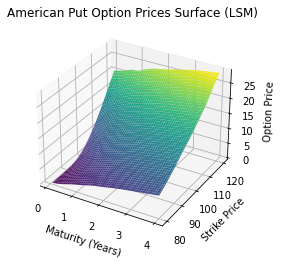

In [ ]:
def price_american_options():
    r = 0.03  # risk-free rate
    S0 = 100  # current stock price
    σ = 0.25  # volatility
    dim = 1_000  # number of simulation paths
    n = 504  # number of exercise rights per year
    seed = 42  # random seed for reproducibility
    poly_degree = 3  # polynomial degree for LSM regression
    # Define maturities and strikes
    maturities = np.array([1/12, 2/12, 3/12, 6/12, 9/12, 1, 15/12, 18/12, 2, 30/12, 3, 4])
    strikes = np.arange(0.8 * S0, 1.21 * S0, 0.05 * S0)

    # Lists to store results
    prices = []
    maturity_list = []
    strike_list = []

    # Iterate over each maturity and strike combination
    for T in maturities:
        for K in strikes:
            # Initialize the Monte Carlo pricer
            mcpricer = MonteCarloOptionPricing(r, S0, K, T, σ, dim, n, seed)
            # Simulate the asset paths
            mcpricer.GeometricBrownianMotion_vec()
            # Price the option using LSM
            option_price = mcpricer.american_option_LSM(poly_degree, otype='put')

            # Store the results
            prices.append(option_price)
            maturity_list.append(T)
            strike_list.append(K)

    return prices, maturity_list, strike_list

# Call the function to get the results
prices, maturities, strikes = price_american_options()

# Convert lists to numpy arrays for processing
maturities_np = np.array(maturities)
strikes_np = np.array(strikes)
prices_np = np.array(prices)

# Creating a grid for maturities and strikes
maturity_grid, strike_grid = np.meshgrid(np.linspace(maturities_np.min(), maturities_np.max(), 100),
                                         np.linspace(strikes_np.min(), strikes_np.max(), 100))

# Interpolating the prices onto the grid
price_grid = griddata((maturities_np, strikes_np), prices_np, (maturity_grid, strike_grid), method='cubic')

# Plotting the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(maturity_grid, strike_grid, price_grid, cmap='viridis', edgecolor='none')
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Option Price')
plt.title('American Put Option Prices Surface (LSM)')

# Save the plot as a PNG file
plt.savefig('OptionsSurfaceLSM.png')

# Display the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp1d
from mpl_toolkits.mplot3d import Axes3D

# Define a range of maturities and strikes
S0 = 100
σ = 0.25
r = 0.03
dim = 1000
n_chebyshev_pol = 100
n_timesteps = 50
seed = 150000

maturities_range = np.array([1/12, 2/12, 3/12, 6/12, 9/12, 1, 15/12, 18/12, 2, 30/12, 3, 4])
strikes_range = np.linspace(0.8 * S0, 1.2 * S0, 10)

# Calculate option prices for each maturity and strike
option_prices = []
maturity_list = []
strike_list = []

for T in maturities_range:
    for K in strikes_range:
        price = chebyshev_option_price(S0, K, T, σ, r, dim, n_chebyshev_pol, n_timesteps, seed)
        option_prices.append(price)
        maturity_list.append(T)
        strike_list.append(K)

# Prepare data for plotting
maturities_np = np.array(maturity_list)
strikes_np = np.array(strike_list)
prices_np = np.array(option_prices)

# Creating a grid for maturities and strikes
maturity_grid, strike_grid = np.meshgrid(np.linspace(maturities_np.min(), maturities_np.max(), 100),
                                         np.linspace(strikes_np.min(), strikes_np.max(), 100))

# Interpolating the prices onto the grid
price_grid = griddata((maturities_np, strikes_np), prices_np, (maturity_grid, strike_grid), method='cubic')

# Plotting the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(maturity_grid, strike_grid, price_grid, cmap='viridis', edgecolor='none')
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Option Price')
plt.title('Option Prices using Chebyshev Method')

# Save the figure
plt.savefig('ChebyshevMethodSurface.png')

# Show the plot
plt.show()

In [9]:
# Source:  https://www.researchgate.net/publication/30758355_Numerical_methods_for_the_valuation_of_financial_derivatives
import scipy.sparse
import scipy.sparse.linalg
import pandas as pd

def Amerput_implicit(S, K, r, sigma, T, N, M):
    dt = T / N
    ds = 2 * S / M
    A = scipy.sparse.lil_matrix((M+1, M+1))
    f = np.maximum(K - np.arange(0, M+1) * ds, 0)

    for m in range(1, M):
        x = 1 / (1 - r * dt)
        A[m, m-1] = x * (r * m * dt - sigma**2 * m**2 * dt) / 2
        A[m, m] = x * (1 + sigma**2 * m**2 * dt)
        A[m, m+1] = x * (-r * m * dt - sigma**2 * m**2 * dt) / 2

    A[0, 0] = 1
    A[M, M] = 1

    for i in range(N, 0, -1):
        f = scipy.sparse.linalg.spsolve(A.tocsr(), f)
        f = np.maximum(f, K - np.arange(0, M+1) * ds)

    P = f[round((M+1) / 2)]
    return P
# Function to calculate prices for different combinations
def calculate_prices(combinations):
    results = []
    for combo in combinations:
        S, sigma, T = combo
        price = Amerput_implicit(S, K, r, sigma, T, N*T, M)
        results.append({
            "S": S,
            "Sigma": sigma,
            "Maturity": T,
            "Price": price
        })
    return results

# Parameters
K = 40  # strike price
r = 0.06  # short-term interest rate
N = 50  # number of time steps per year
M = 1000  # spatial steps

# Combinations of S, sigma, and T
combinations = [
    (36, 0.20, 1), (36, 0.20, 2), (36, 0.40, 1), (36, 0.40, 2),
    (38, 0.20, 1), (38, 0.20, 2), (38, 0.40, 1), (38, 0.40, 2),
    (40, 0.20, 1), (40, 0.20, 2), (40, 0.40, 1), (40, 0.40, 2),
    (42, 0.20, 1), (42, 0.20, 2), (42, 0.40, 1), (42, 0.40, 2),
    (44, 0.20, 1), (44, 0.20, 2), (44, 0.40, 1), (44, 0.40, 2)
]

# Calculate prices
results = calculate_prices(combinations)

# Convert results to a DataFrame for better visualization
df = pd.DataFrame(results)
print(df)

     S  Sigma  Maturity     Price
0   36    0.2         1  4.464959
1   36    0.2         2  4.829426
2   36    0.4         1  7.075359
3   36    0.4         2  8.414515
4   38    0.2         1  3.236798
5   38    0.2         2  3.734485
6   38    0.4         1  6.122398
7   38    0.4         2  7.593174
8   40    0.2         1  2.301416
9   40    0.2         2  2.875075
10  40    0.4         1  5.287724
11  40    0.4         2  6.855543
12  42    0.2         1  1.606117
13  42    0.2         2  2.203934
14  42    0.4         1  4.559553
15  42    0.4         2  6.193117
16  44    0.2         1  1.101470
17  44    0.2         2  1.682617
18  44    0.4         1  3.926463
19  44    0.4         2  5.598173
